In [ ]:
import sys
sys.path.append("..")

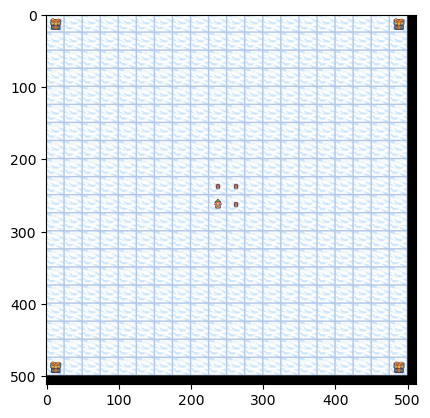

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt
from mango.utils import generate_map

grid_size = 20
grid_shape = (grid_size, grid_size)

env = gym.make(
    "FrozenLake-v1",
    desc=generate_map(size=grid_size, p=0.999, mirror=True),
    is_slippery=False,
    render_mode="rgb_array",
)

env.reset()
plt.imshow(env.render())
plt.show()

In [ ]:
from mango.concepts import Int2CoordConcept
from mango.actions import GridCompatibility

base_concept = Int2CoordConcept(grid_shape, cell_shape=(1, 1))
concepts = [
    Int2CoordConcept(grid_shape, cell_shape=(2, 2)),
    Int2CoordConcept(grid_shape, cell_shape=(4, 4)),
]
action_compatabilities = [
    GridCompatibility(),
    GridCompatibility(),
]

In [ ]:
from mango.mango import Mango

mango = Mango(
    environment=env,
    concepts=concepts,
    action_compatibilities=action_compatabilities,
    base_concept=base_concept,
)
print(mango)
print(f"{mango.option_space=}")

c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Mango(
  (0): MangoEnv(
    (concept): Int2CoordConcept(global_shape=(20, 20), cell_shape=(1, 1))
    (environment): <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
  )
  (1): MangoEnv(
    (concept): Int2CoordConcept(global_shape=(20, 20), cell_shape=(1, 1))
    (environment): <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
  )
  (2): MangoLayer(
    (concept): Int2CoordConcept(global_shape=(20, 20), cell_shape=(2, 2))
    (act_comp): GridCompatibility()
    (policy): DQnetPolicyMapper(
      (0): DQnetPolicy(action_space=Discrete(4))
      (1): DQnetPolicy(action_space=Discrete(4))
      (2): DQnetPolicy(action_space=Discrete(4))
      (3): DQnetPolicy(action_space=Discrete(4))
    )
  )
  (3): MangoLayer(
    (concept): Int2CoordConcept(global_shape=(20, 20), cell_shape=(4, 4))
    (act_comp): GridCompatibility()
    (policy): DQnetPolicyMapper(
      (0): DQnetPolicy(action_space=Discrete(4))
      (1): DQnetPolicy(action_sp

c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
from tqdm.notebook import tqdm
import numpy as np

N = 1000
for layer in [1,2]:
    for randomness in (pbar := tqdm(np.linspace(1.0, 0.0, N))):
        pbar.set_description(f"randomness: {randomness:.3f}")
        mango.set_randomness(randomness, layer=layer)
        mango.explore(layer=layer, episode_length=5)
        mango.train()    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

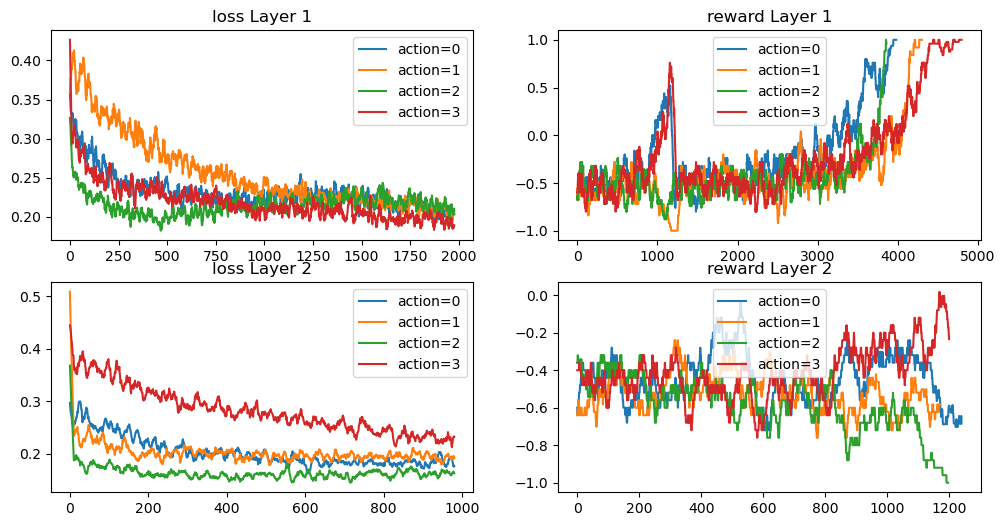

In [ ]:
from mango.utils import smooth

plt.figure(figsize=(12, 6))
for layer_idx, layer in enumerate(mango.abstract_layers, start=1):
    for action in range(layer.action_space.n):
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+1)
        plt.title(f"loss Layer {layer_idx}")
        plt.plot(smooth(layer.train_loss_log[action]), label=f"{action=}")
        plt.legend()
    
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+2)
        plt.title(f"reward Layer {layer_idx}")
        plt.plot(smooth(layer.intrinsic_reward_log[action], window=50), label=f"{action=}")
        plt.legend()

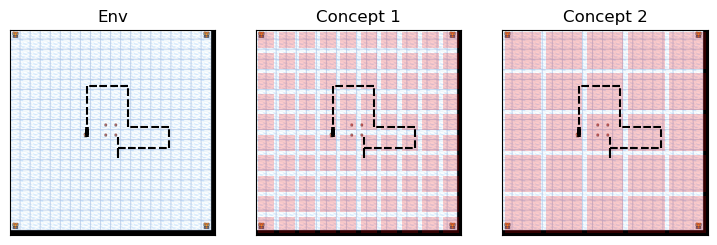

In [ ]:
from mango.utils import plot_grid, plot_trajectory
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# spyral trajectory
planned_trajectory = [UP, RIGHT, DOWN, DOWN, LEFT, LEFT, UP, UP, UP]

start_state, info = mango.reset()
trajetory = [start_state]
for action in planned_trajectory:
    end_state, reward, trunc, term, info = mango.execute_option(layer=2, action=action)
    trajetory.extend(info["mango:trajectory"])
    
img = env.render()
plt.figure(figsize=((1 + len(concepts)) * 3, 3))
for i, concept in enumerate([None] + concepts):
    plt.subplot(1, len(concepts) + 1, 1 + i)
    plt.title("Env" if concept is None else f"Concept {i}")
    plt.imshow(img)
    if concept is not None:
        plot_grid(grid_shape, concept.cell_shape) # type: ignore
    plot_trajectory(start_state, trajetory, grid_shape)
    plt.xticks([])
    plt.yticks([])
plt.show()